### Imports and Directory Setup

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Network Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Path setup based on your folder structure
data_path = './Data/' 
train_path = os.path.join(data_path, 'Train/')
num_classes = 43

### Loading and Resizing Training Data

In [2]:
train_data = []
train_labels = []
train_folders = os.listdir(train_path)

for folder in tqdm.tqdm(train_folders):
    folder_full_path = os.path.join(train_path, folder)
    # Skip non-directory files
    if not os.path.isdir(folder_full_path):
        continue
        
    imagefiles = os.listdir(folder_full_path)
    for imagefile in imagefiles:
        try:
            path = os.path.join(folder_full_path, imagefile)
            image = Image.open(path)
            image = image.resize((32, 32))
            image = np.array(image)
            train_data.append(image)
            train_labels.append(int(folder))
        except Exception as e:
            pass # Skips system files or corrupt images

100%|██████████| 43/43 [03:34<00:00,  4.99s/it]


### Convert Lists to NumPy Arrays

In [3]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

### Verification

In [4]:
print("There are {} images in train dataset".format(len(train_data)))
print("Each image has a dimension of : {}".format(train_data[0].shape))

There are 39209 images in train dataset
Each image has a dimension of : (32, 32, 3)


### Train-Validation Split and One-Hot Encoding

In [5]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size = 0.2, stratify = train_labels, random_state = 42)

# Get counts for plotting
train_unique, y_train_count = np.unique(y_train, return_counts = True)
val_unique, y_val_count = np.unique(y_val, return_counts = True)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(31367, 32, 32, 3) (31367, 43) (7842, 32, 32, 3) (7842, 43)


### Visualizing the Splits

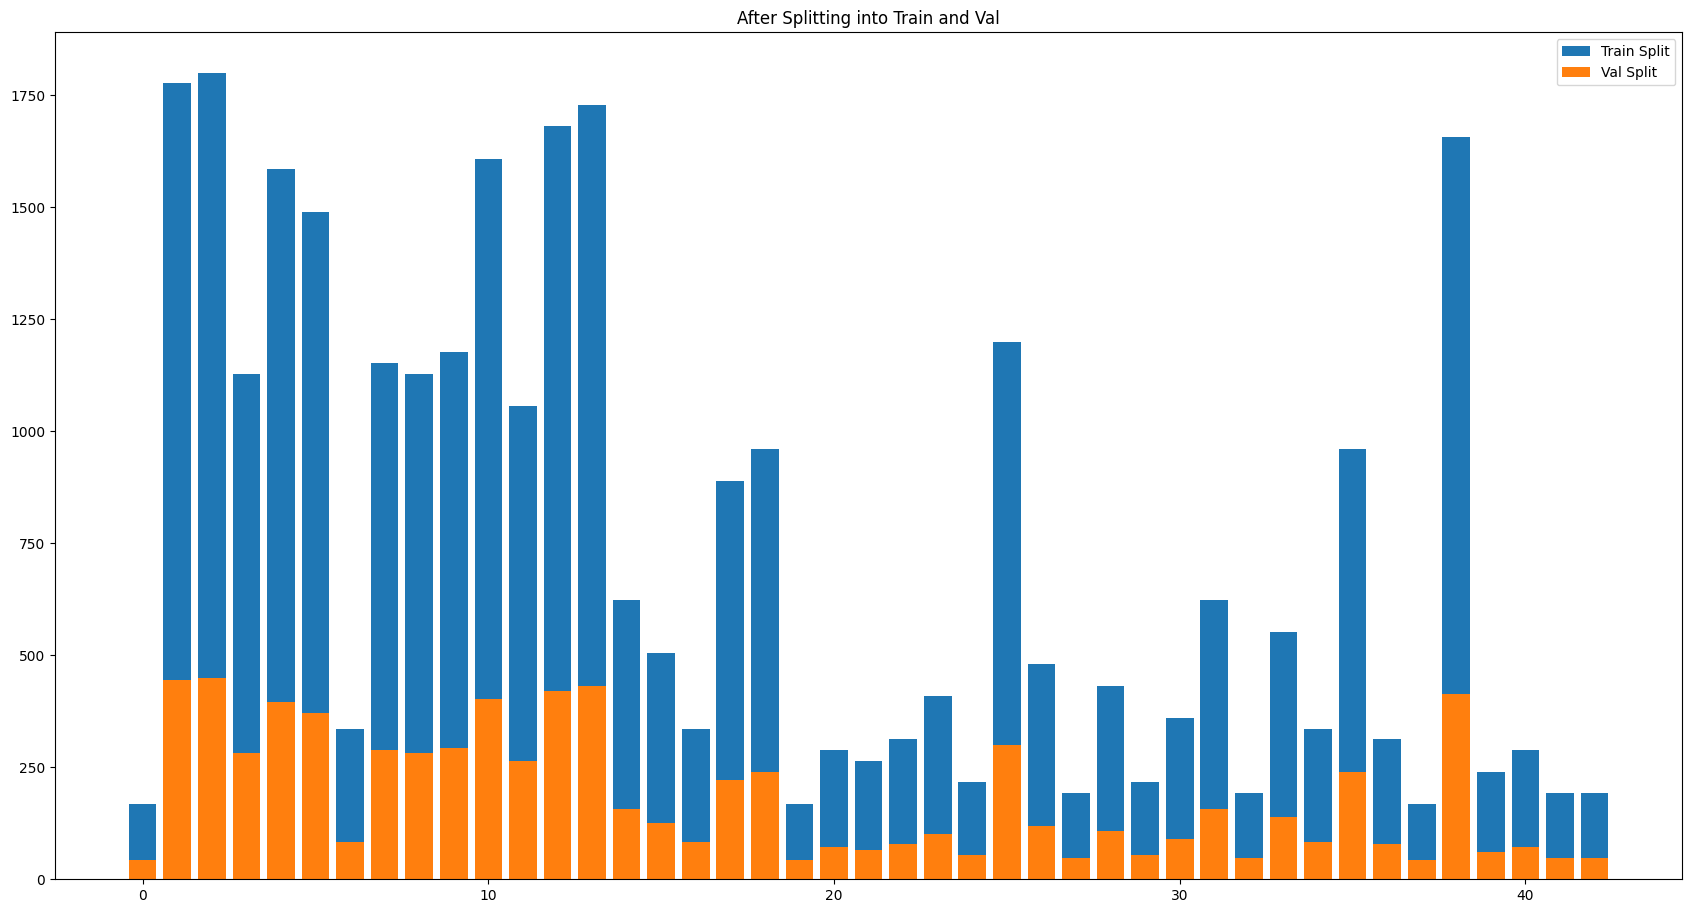

In [6]:
plt.figure(figsize = (21, 11))
plt.bar(train_unique, y_train_count)
plt.bar(val_unique, y_val_count)
plt.legend(['Train Split', 'Val Split'], loc = 'upper right')
plt.title("After Splitting into Train and Val")
plt.show()

### Loading and Arraying Test Data

In [7]:
# Loading Test.csv from your Data folder
test_csv_path = os.path.join(data_path, 'Test.csv')
df_test = pd.read_csv(test_csv_path)

test_data = []
test_labels = df_test.ClassId.values
# Joining 'Data' with the relative path in the CSV (e.g., 'Test/0000.png')
test_filenames = [os.path.join(data_path, p) for p in df_test.Path]

for test_filename in tqdm.tqdm(test_filenames):
    try:
        image = Image.open(test_filename).resize((32, 32))
        test_data.append(np.array(image))
    except Exception as e:
        print(f"Error loading {test_filename}: {e}")

X_test = np.array(test_data)
y_test = np.array(test_labels)

100%|██████████| 12630/12630 [01:07<00:00, 186.03it/s]


### Final Distribution Table and Plot

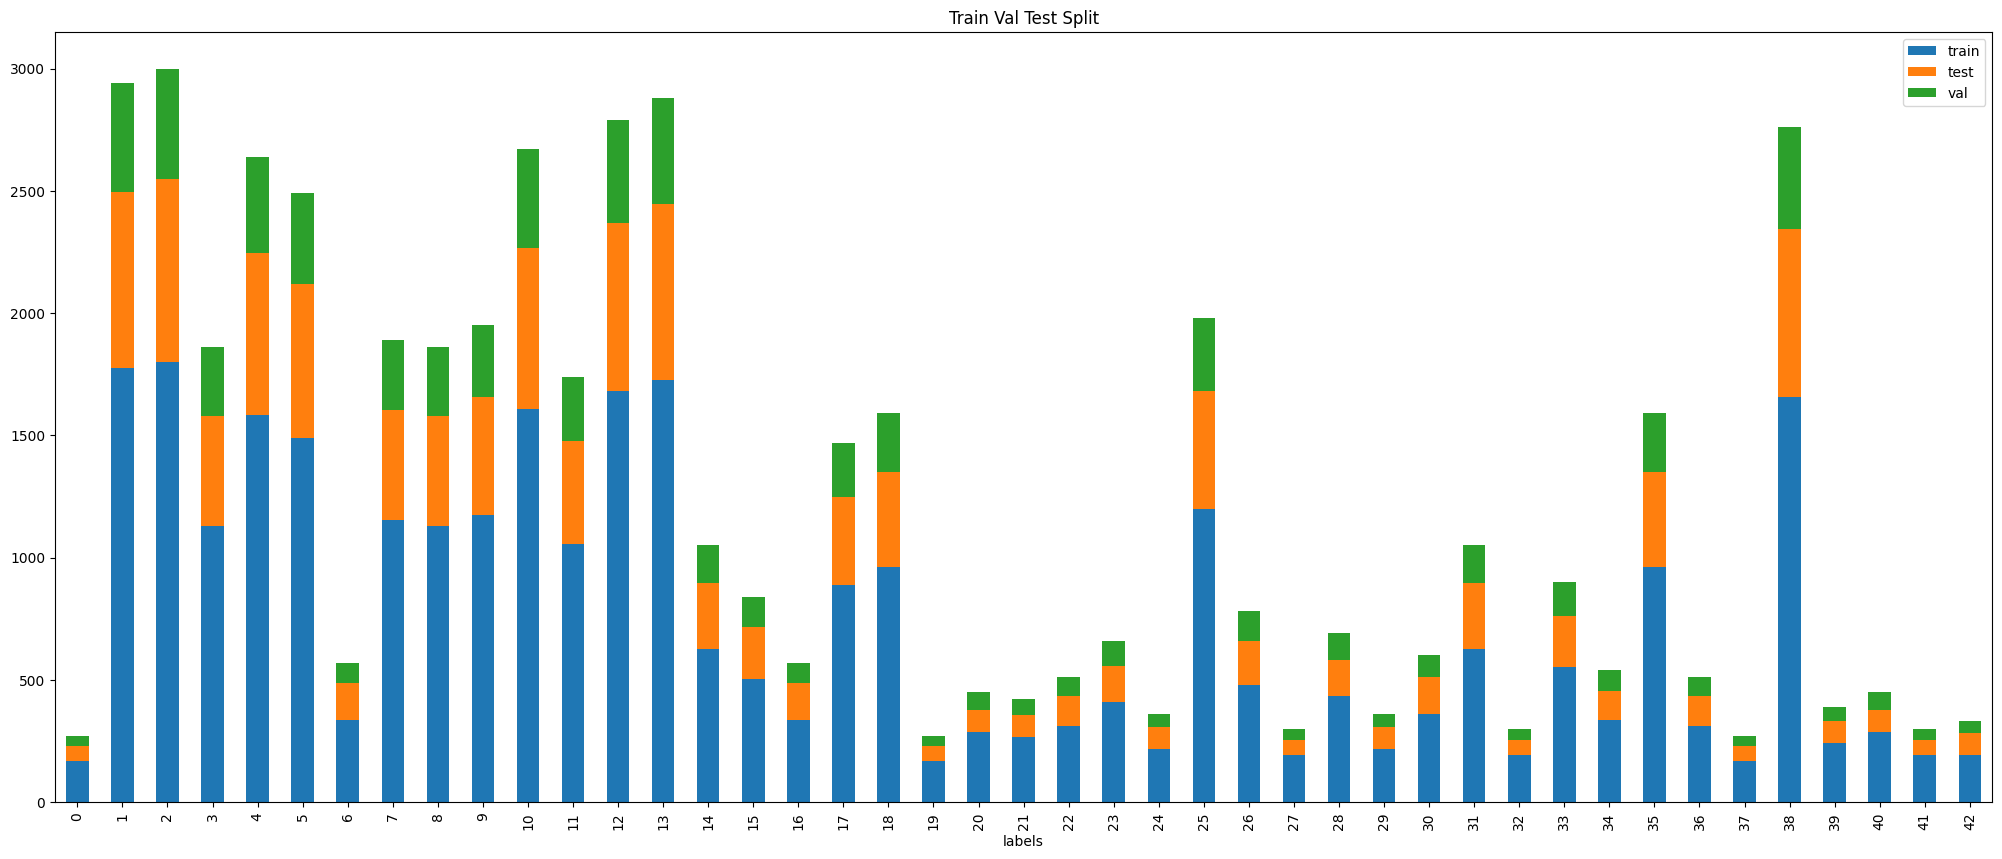

In [8]:
test_unique, y_test_count = np.unique(y_test, return_counts = True)

df_balance = pd.DataFrame({'labels': train_unique, 'train': y_train_count, 'val': y_val_count})
df_balance['test'] = y_test_count

df_balance.plot.bar(x = 'labels', y = ['train', 'test', 'val'], figsize = (25, 10), stacked = True, title = "Train Val Test Split")
plt.show()

### Define Model Architecture

In [9]:
def get_compiled_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Normalization

In [10]:
X_train, X_val, X_test = X_train/255., X_val/255., X_test/255.

### Training

In [11]:
model = get_compiled_model()
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose = True)

d:\Akash\Codes\Projects\Traffic_Sign_Detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6854 - loss: 1.1194 - val_accuracy: 0.9707 - val_loss: 0.1180
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9405 - loss: 0.1945 - val_accuracy: 0.9890 - val_loss: 0.0486
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9657 - loss: 0.1145 - val_accuracy: 0.9925 - val_loss: 0.0304
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9742 - loss: 0.0845 - val_accuracy: 0.9945 - val_loss: 0.0228
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9774 - loss: 0.0705 - val_accuracy: 0.9944 - val_loss: 0.0259
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9820 - loss: 0.0607 - val_accuracy: 0.9943 - val_loss: 0.0247
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9842 - loss: 0.0547 - val_accuracy: 0.9949 - val_loss: 0.0226
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9834 - loss: 0.0549 - 

### History Plots

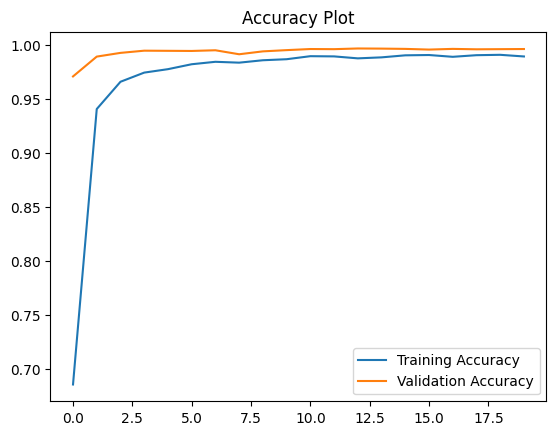

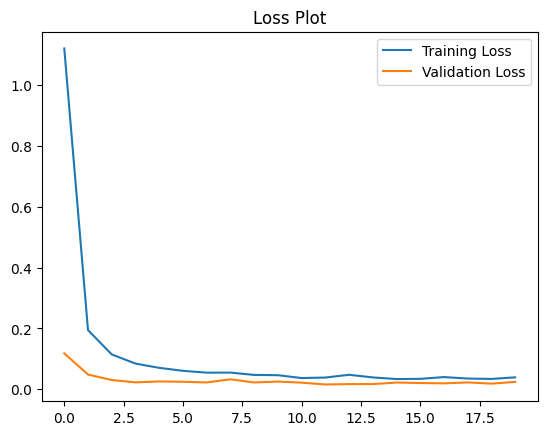

In [12]:
# Accuracy Plot
plt.figure()
acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
plt.plot(history.history[acc_key], label = "Training Accuracy")
plt.plot(history.history['val_'+acc_key], label = "Validation Accuracy")
plt.title("Accuracy Plot")
plt.legend()
plt.show()

# Loss Plot
plt.figure()
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.title("Loss Plot")
plt.legend()
plt.show()

### Evaluation and Heatmap

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test Accuracy Score:  0.9734758511480601


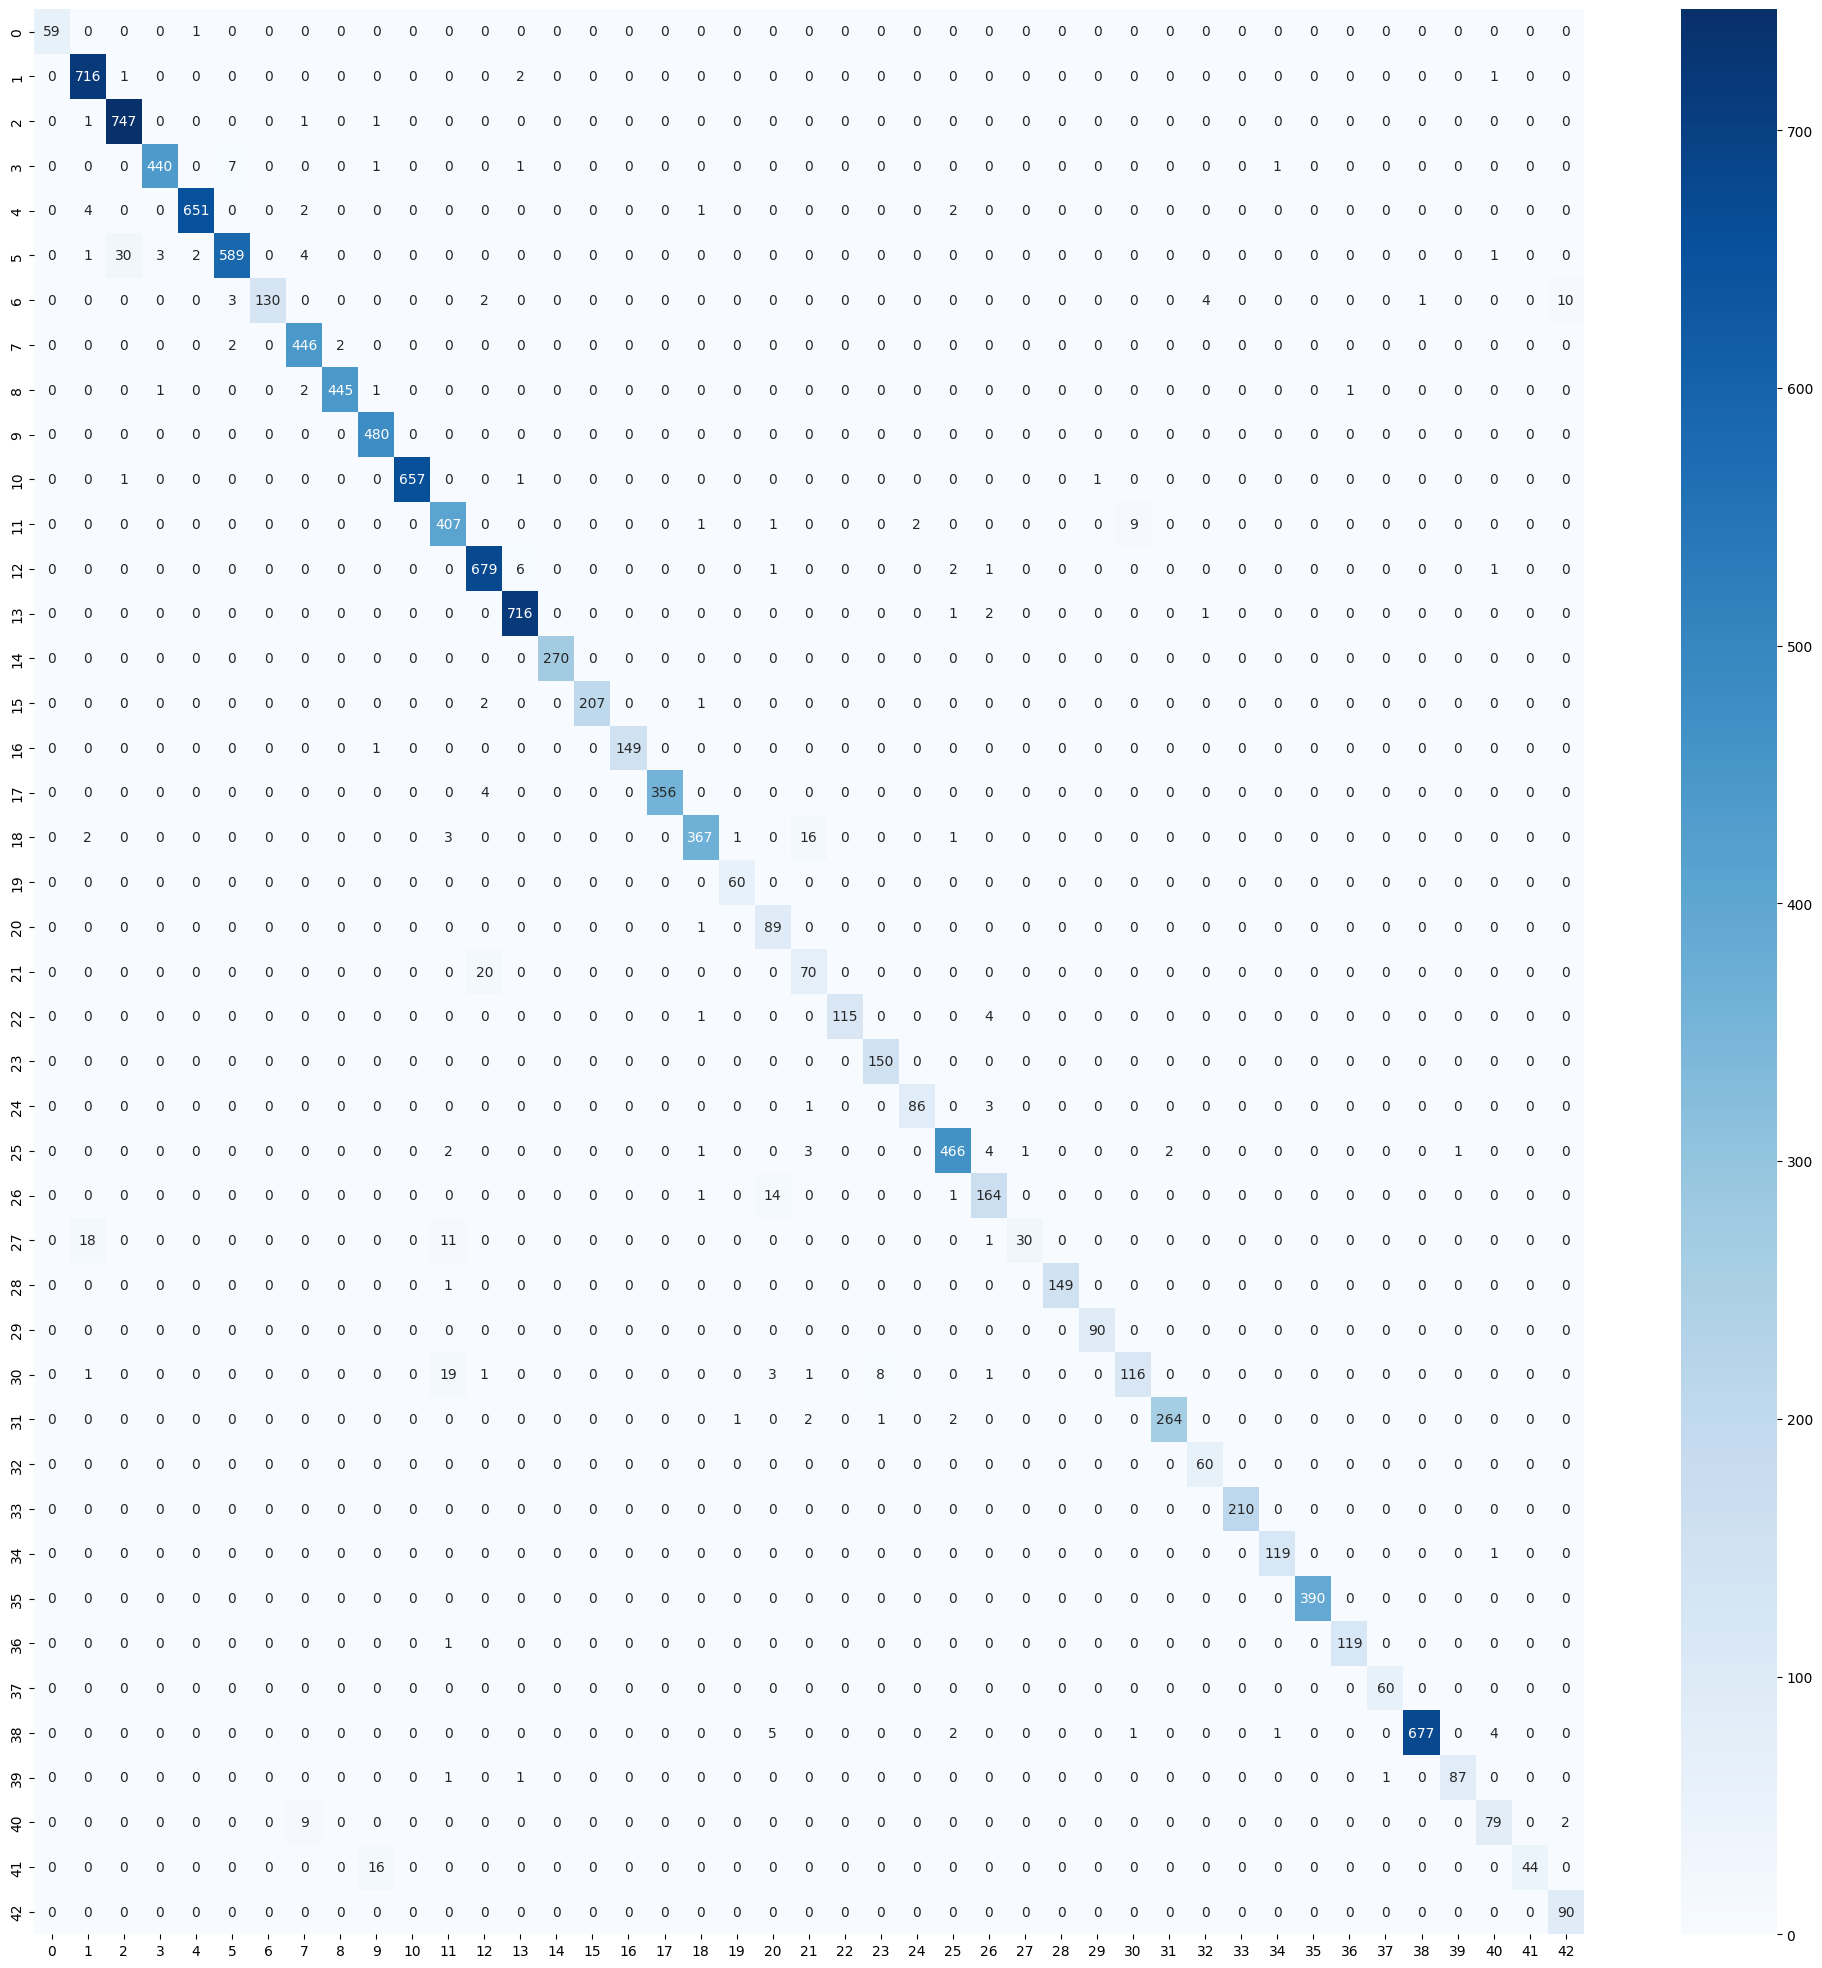

In [13]:
# Modern prediction approach
predictions = np.argmax(model.predict(X_test), axis=-1)

cfm = confusion_matrix(y_test, predictions)
print("Test Accuracy Score: ", accuracy_score(y_test, predictions))

df_cfm = pd.DataFrame(cfm, index = range(43), columns = range(43))
plt.figure(figsize = (25, 25))
sns.heatmap(df_cfm, annot=True, fmt='d', cmap='Blues')
plt.show()

### Visualizing Test Predictions

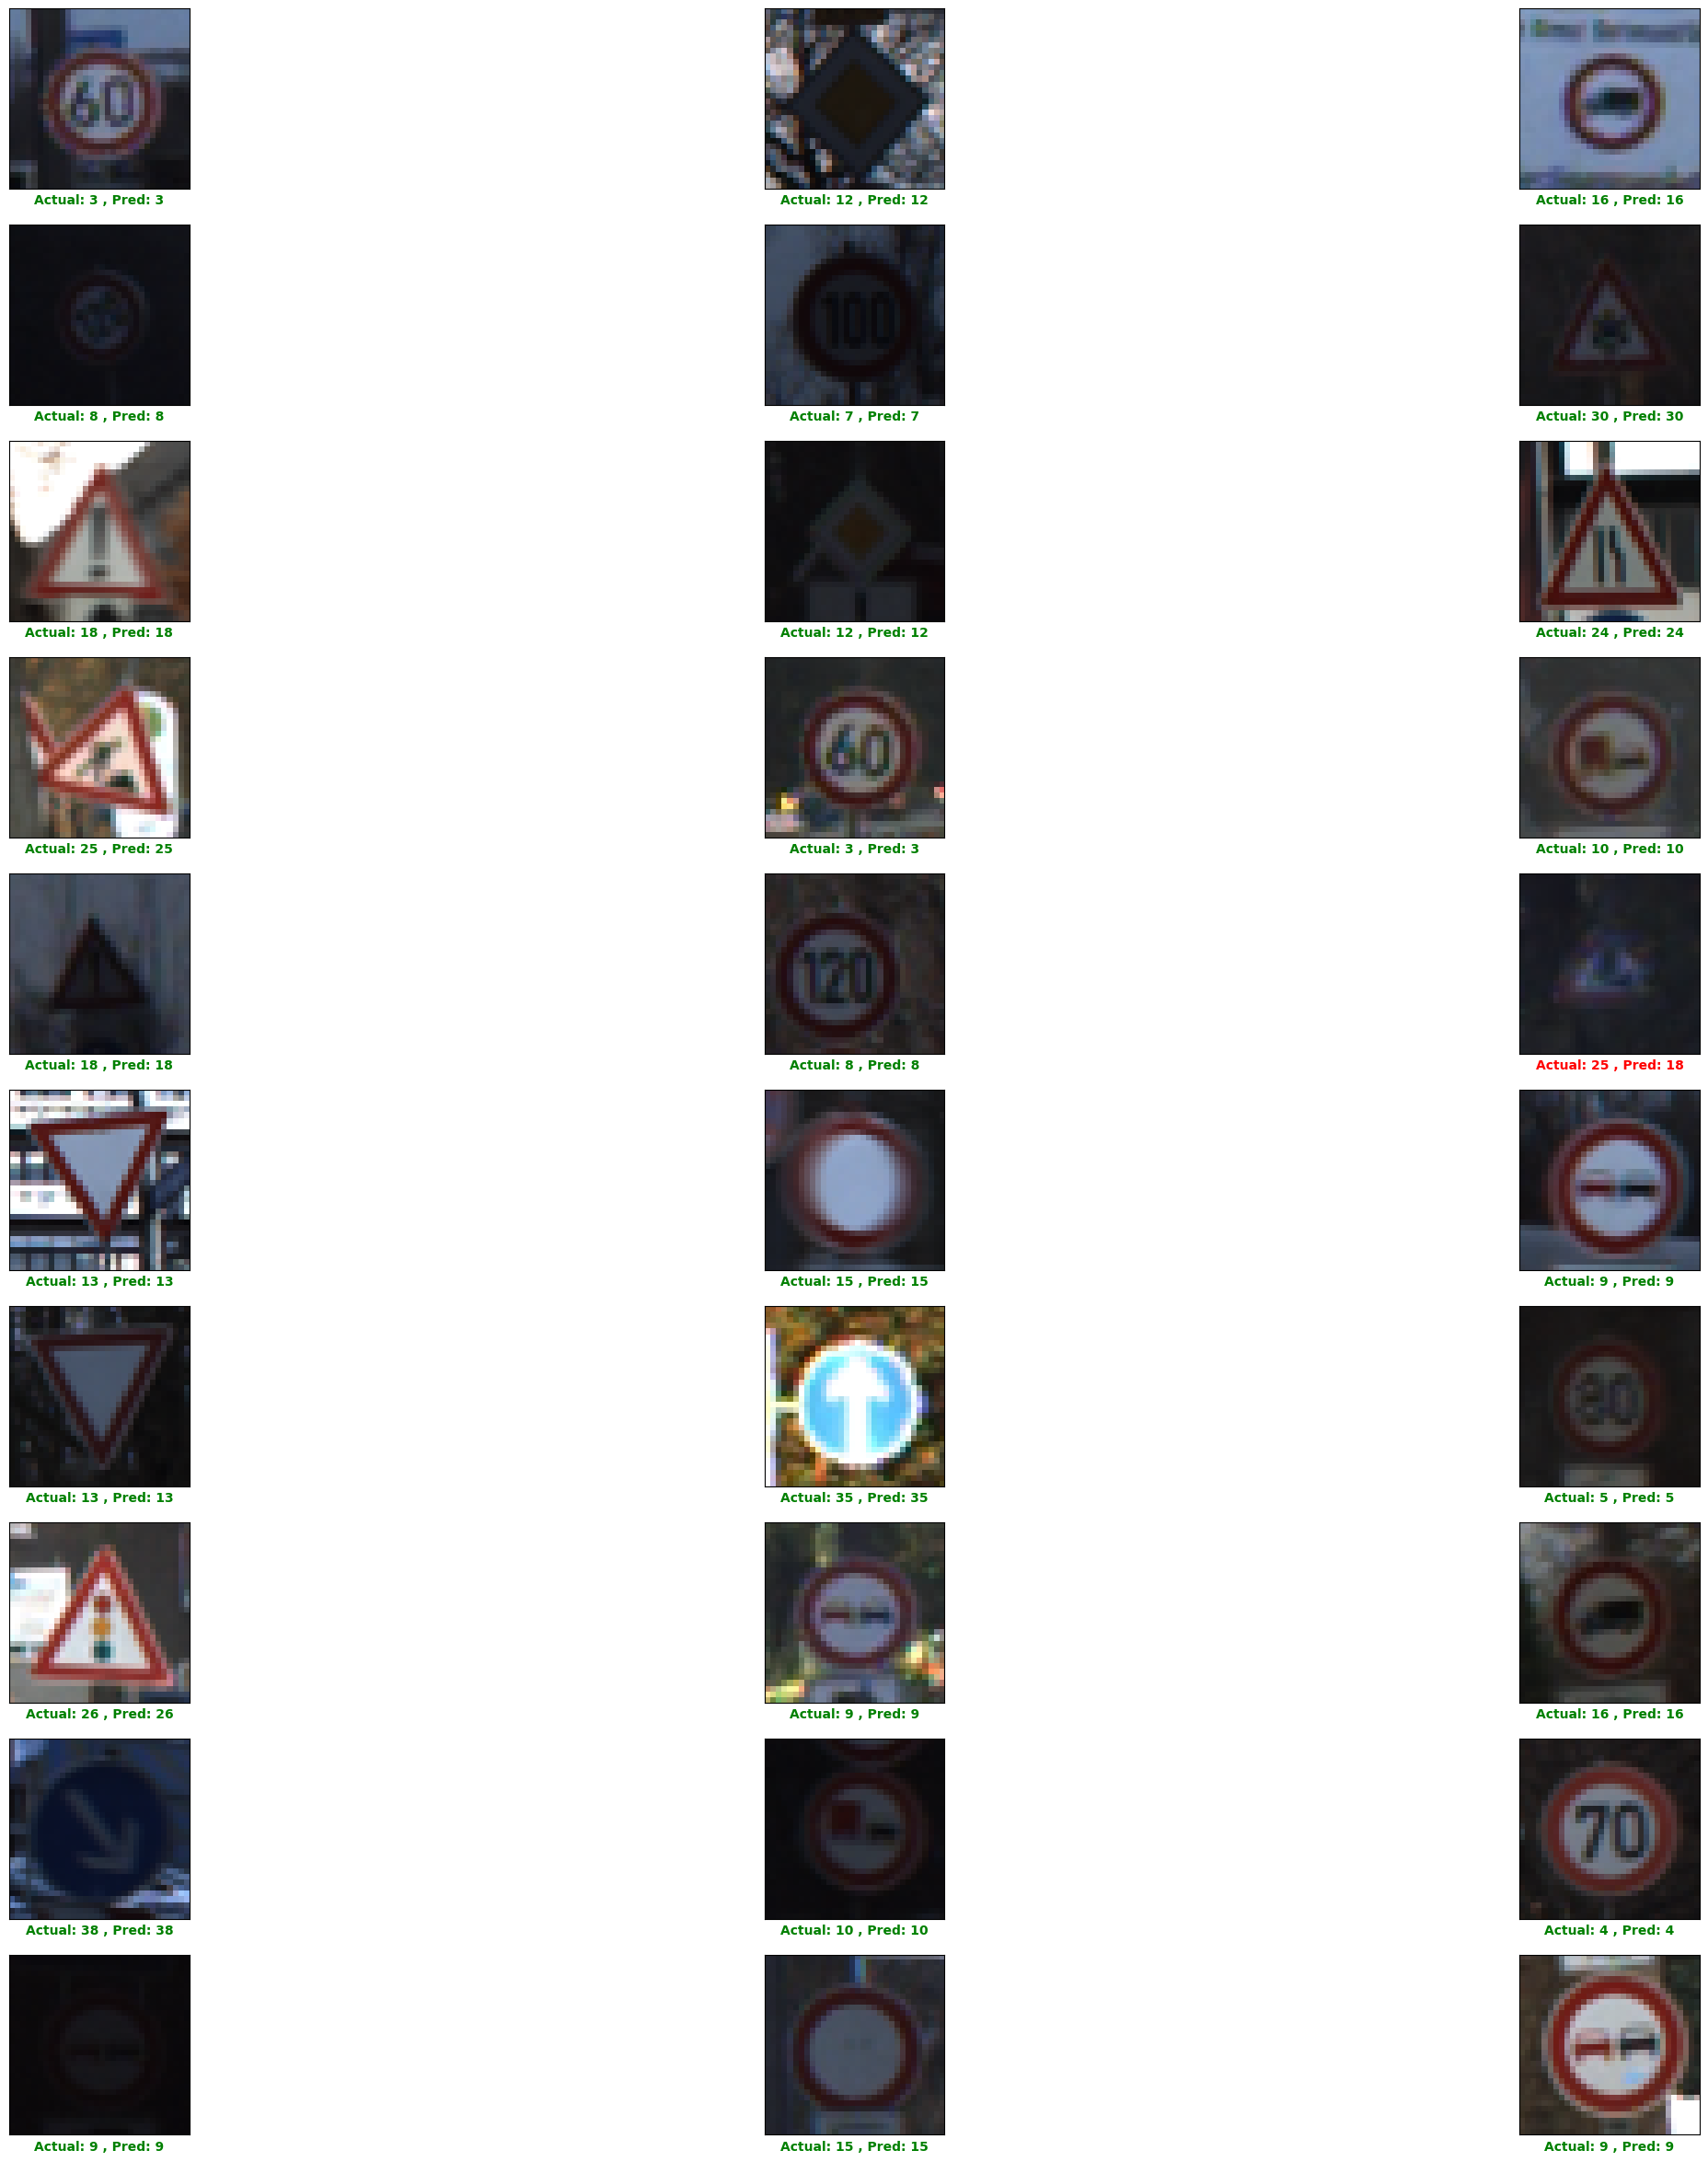

In [14]:
plt.figure(figsize = (30, 30))
start_index = 36 
for i in range(30):
    plt.subplot(10, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred = predictions[start_index + i]
    actual = y_test[start_index + i]
    
    col = 'g' if pred == actual else 'r'
    plt.xlabel('Actual: {} , Pred: {}'.format(actual, pred), color = col, weight = 'bold')
    plt.imshow(X_test[start_index + i])
plt.show()

### Save Model

In [15]:
if not os.path.exists('models'):
    os.mkdir('models')
model.save('models/traffic_sign_detection_gtsrb.h5')

### Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


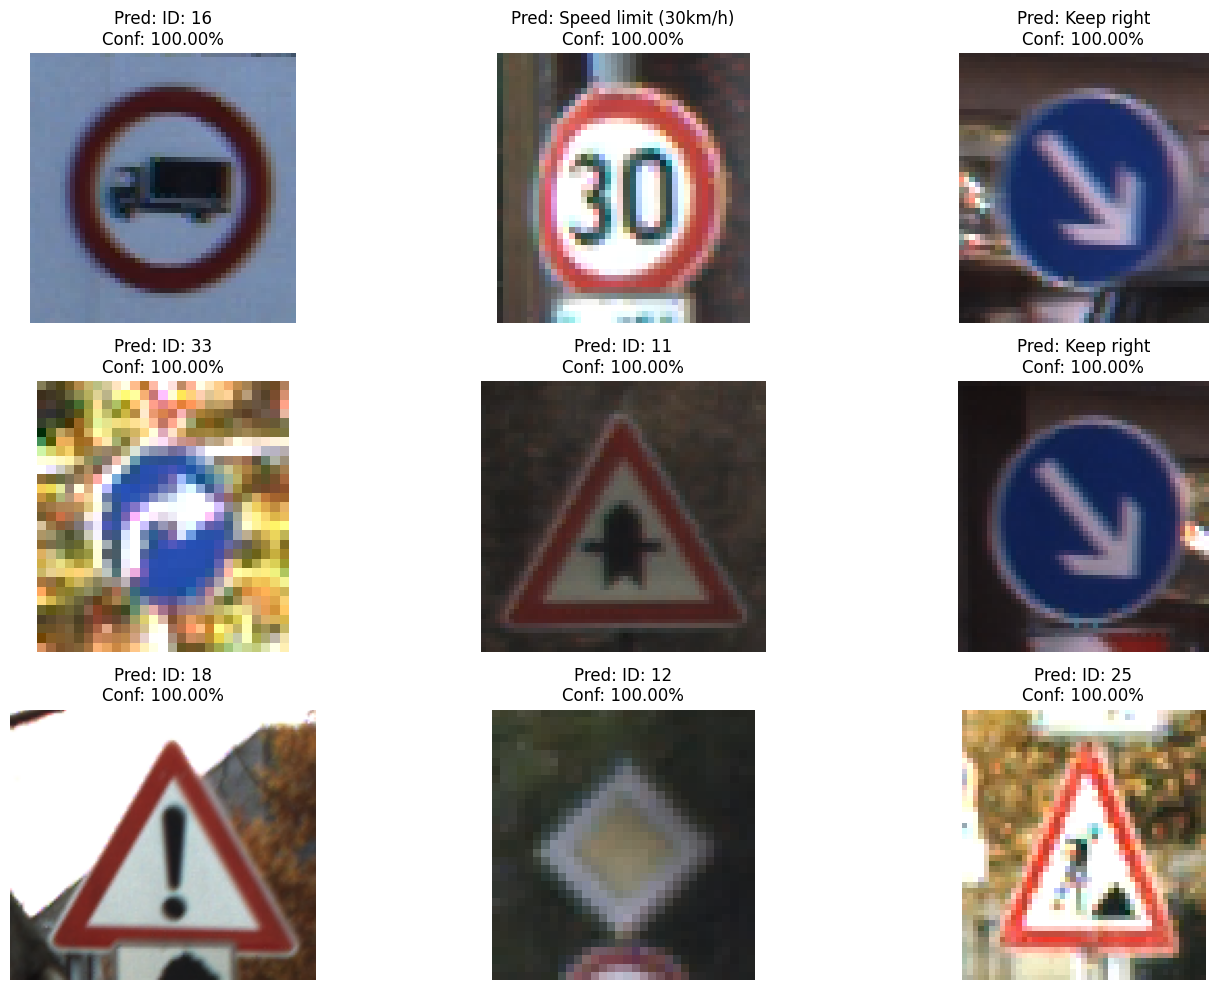

In [16]:
from tensorflow.keras.models import load_model

# 1. Load the model and define class names
model = load_model('./models/traffic_sign_detection_gtsrb.h5')
class_names = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 
            3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 
            13: 'Yield', 14: 'Stop', 17: 'No entry', 35: 'Ahead only', 38: 'Keep right'} # ... (add others as needed)

def predict_multiple(folder_path, grid_rows=3, grid_cols=3):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images_to_predict = []
    original_images = []

    # Prepare images
    for filename in image_files[:grid_rows * grid_cols]:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        original_images.append(img)
        
        # Preprocess for model
        img_resized = img.resize((32, 32))
        img_array = np.array(img_resized).astype('float32') / 255.0
        images_to_predict.append(img_array)

    # Convert to a single batch NumPy array
    batch_array = np.array(images_to_predict)

    # Make predictions on the whole batch
    predictions = model.predict(batch_array)
    predicted_classes = np.argmax(predictions, axis=-1)
    confidences = np.max(predictions, axis=-1)

    # Visualize in a grid
    plt.figure(figsize=(15, 10))
    for i in range(len(images_to_predict)):
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(original_images[i])
        
        class_idx = predicted_classes[i]
        label = class_names.get(class_idx, f"ID: {class_idx}")
        
        plt.title(f"Pred: {label}\nConf: {confidences[i]:.2%}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the prediction on your folder
predict_multiple('./Data/Test')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


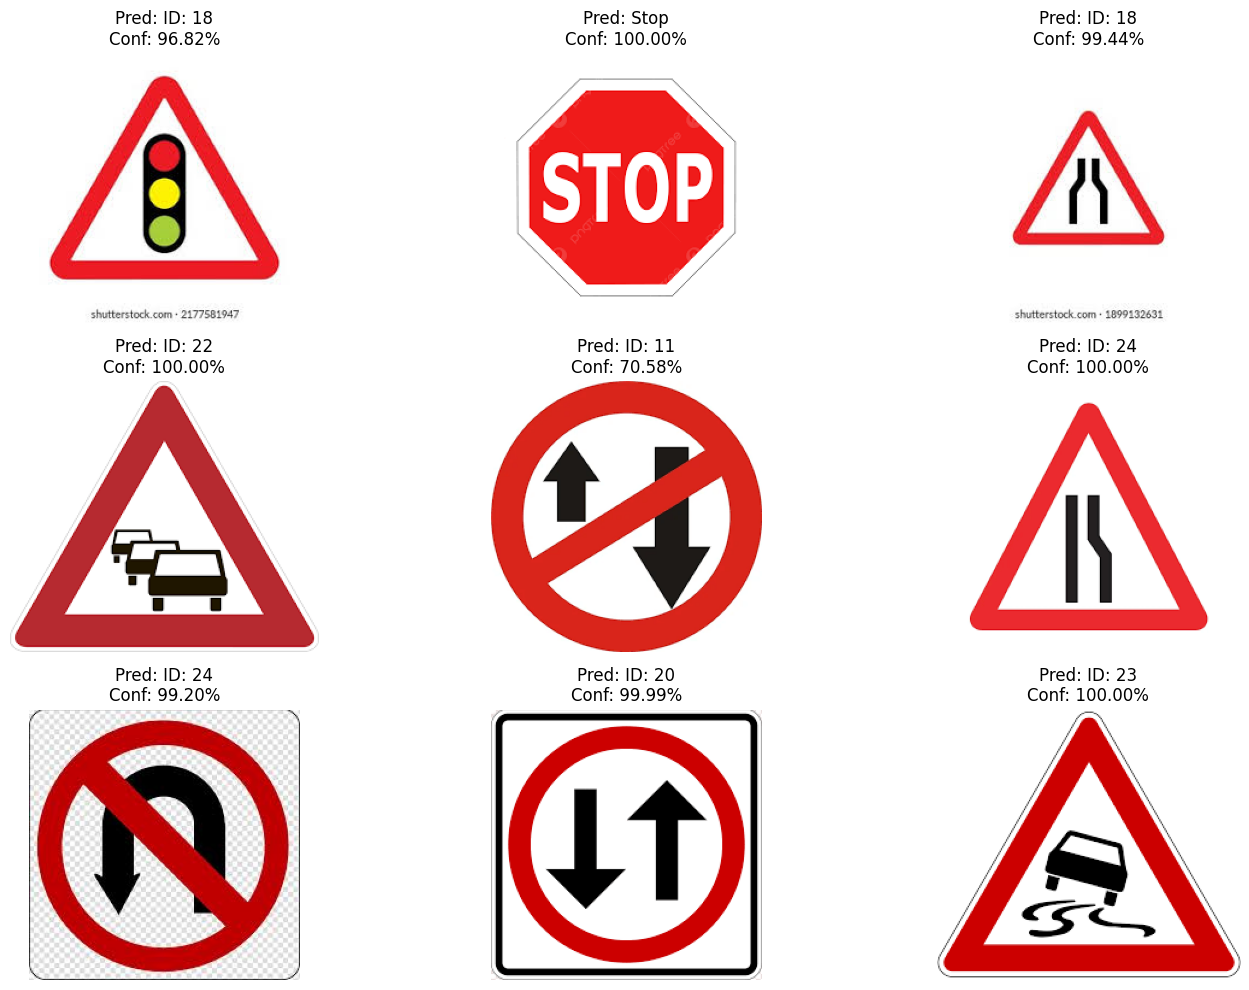

In [17]:
from tensorflow.keras.models import load_model

# 1. Load the model and define class names
model = load_model('./models/traffic_sign_detection_gtsrb.h5')
class_names = {0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 
            3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 
            13: 'Yield', 14: 'Stop', 17: 'No entry', 35: 'Ahead only', 38: 'Keep right'} # ... (add others as needed)

def predict_multiple(folder_path, grid_rows=3, grid_cols=3):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images_to_predict = []
    original_images = []

    # Prepare images
    for filename in image_files[:grid_rows * grid_cols]:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        original_images.append(img)
        
        # Preprocess for model
        img_resized = img.resize((32, 32))
        img_array = np.array(img_resized).astype('float32') / 255.0
        images_to_predict.append(img_array)

    # Convert to a single batch NumPy array
    batch_array = np.array(images_to_predict)

    # Make predictions on the whole batch
    predictions = model.predict(batch_array)
    predicted_classes = np.argmax(predictions, axis=-1)
    confidences = np.max(predictions, axis=-1)

    # Visualize in a grid
    plt.figure(figsize=(15, 10))
    for i in range(len(images_to_predict)):
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(original_images[i])
        
        class_idx = predicted_classes[i]
        label = class_names.get(class_idx, f"ID: {class_idx}")
        
        plt.title(f"Pred: {label}\nConf: {confidences[i]:.2%}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the prediction on your folder
predict_multiple('./new_Images/')